In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl
import torchmetrics
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import dtreeviz

In [2]:
SEED = 2024
pl.seed_everything(SEED)

Seed set to 2024


2024

## Utils

In [5]:
LEARING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


In [94]:
def correlation_matrix(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(title)
    plt.show()

In [64]:
def load_data(batch_size=BATCH_SIZE, num_workers=4):
    # Transformaciones para los datos
    transform = transforms.ToTensor()

    # Carga de datos de entrenamiento
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    
    # División entre entrenamiento y validación
    train_size = int(0.8 * len(mnist_train))
    val_size = len(mnist_train) - train_size
    mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

    # DataLoader para entrenamiento y validación
    train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True, persistent_workers=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers, shuffle=False, persistent_workers=True)

    # Carga de datos de test
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data()

In [6]:

class MNISTModel(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super(MNISTModel, self).__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)
        self.lr = lr
        self.num_classes = num_classes
        
        # metrics
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.precision = torchmetrics.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.recall = torchmetrics.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.f1 = torchmetrics.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')

    def forward(self, x, record_activations=False):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x_layer1 = F.relu(x)

        x = self.layer_2(x_layer1)
        x_layer2 = F.relu(x)

        x = self.layer_3(x_layer2)
        x_layer3 = F.log_softmax(x, dim=1)

        if record_activations:
            return x_layer3, [x_layer1, x_layer2, x_layer3]

        return x_layer3
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc(logits, y), prog_bar=True)
        self.log('precision', self.precision(logits, y), prog_bar=True)
        self.log('recall', self.recall(logits, y), prog_bar=True)
        self.log('f1', self.f1(logits, y), prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
model = MNISTModel(lr=LEARING_RATE)

## Train

In [6]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: c:\code\ExAI\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 33.0 K
2 | layer_3   | Linear              | 2.6 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
trainer.test(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.9688427448272705     │
│         precision         │    0.9722179770469666     │
│          recall           │    0.9713566303253174     │
│         test_acc          │    0.9731000065803528     │
│         test_loss         │    0.08862943947315216    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08862943947315216,
  'test_acc': 0.9731000065803528,
  'precision': 0.9722179770469666,
  'recall': 0.9713566303253174,
  'f1': 0.9688427448272705}]

## Activations

In [8]:
def load_data_for_activations():
    # load only one image of the test set
    transform = transforms.ToTensor()
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)
    return test_loader

test_loader_act = load_data_for_activations()

In [9]:
model_for_act = MNISTModel.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt')
model_for_act.eval()

MNISTModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)

In [19]:
# Número de neuronas en cada capa
layer1_neurons = 128 
layer2_neurons = 256 
layer3_neurons = 10 

# Creación de las columnas para cada neurona
columns = ['Number']
columns += [f'Layer1_Neuron{i+1}' for i in range(layer1_neurons)]
columns += [f'Layer2_Neuron{i+1}' for i in range(layer2_neurons)]
columns += [f'Layer3_Neuron{i+1}' for i in range(layer3_neurons)]

# Estimación del tamaño del DataFrame (ajusta según tu conjunto de datos)
num_rows = len(test_loader_act) 

# Pre-creación del DataFrame
df = pd.DataFrame(index=range(num_rows), columns=columns)

# Llenar el DataFrame
for idx, batch in enumerate(tqdm(test_loader_act, desc='Running activations')):
    x, y = batch
    _, r = model_for_act(x, record_activations=True)

    # Construir fila para el DataFrame
    row = {'Number': y.item()}
    row.update({f'Layer1_Neuron{i+1}': r[0].cpu().detach().numpy()[0, i] for i in range(layer1_neurons)})
    row.update({f'Layer2_Neuron{i+1}': r[1].cpu().detach().numpy()[0, i] for i in range(layer2_neurons)})
    row.update({f'Layer3_Neuron{i+1}': r[2].cpu().detach().numpy()[0, i] for i in range(layer3_neurons)})

    df.loc[idx] = row

Running activations: 100%|██████████| 10000/10000 [00:23<00:00, 417.17it/s]


In [20]:
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.0,0.0,0.0,0.0,0.0,0.196717,0.0,0.0,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.01362,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.0,0.0,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.0,1.838184,0.470426,0.2989,0.0,0.16031,1.212221,0.0,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.0,0.0,0.0,0.0,1.68934,0.451246,0.0,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.45652
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782253,2.228824,...,-11.6886,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [21]:
# save activations csv
df.to_csv('activations.csv', index=False)

## Study activation

In [5]:
# read activations csv
folder = os.path.join(os.getcwd(), 'activations', 'activations.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.000000,0.000000,0.000000,0.000000,0.000000,0.196717,0.000000,0.000000,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.000000,0.000000,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.000000,1.838184,0.470426,0.298900,0.000000,0.160310,1.212221,0.000000,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.000000,0.000000,0.000000,0.000000,1.689340,0.451246,0.000000,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782253,2.228824,...,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [6]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

# create new dataframe
df_layer1 = df[get_layer_columns('Layer1')]
df_layer1.head()

# create new dataframe
df_layer2 = df[get_layer_columns('Layer2')]
df_layer2.head()

# create new dataframe
df_layer3 = df[get_layer_columns('Layer3')]
df_layer3.head()

,Number,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


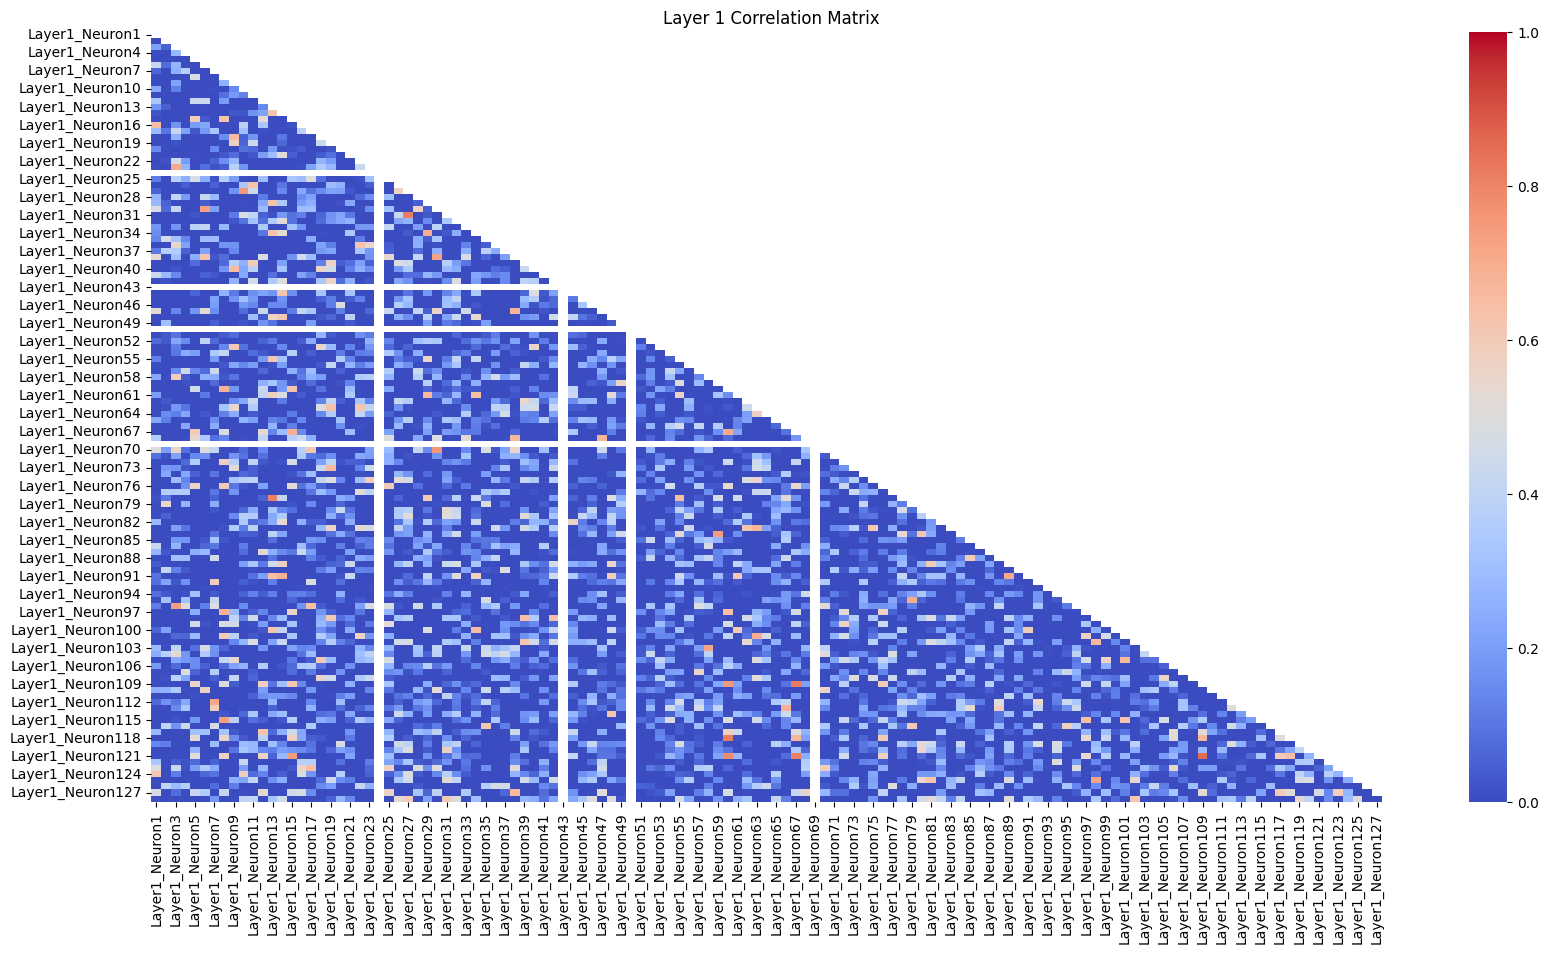

In [24]:
# plot correlation matrix
df_layer1_not_number = df_layer1.drop(columns=['Number'])
correlation_matrix(df_layer1_not_number, 'Layer 1 Correlation Matrix')


### IoU of activations

In [67]:
def IoU(data, num_classes=10, threshold = 0.1):
    activation = data.copy()
    # Binarizar las activaciones
    activation = activation.gt(threshold).astype(bool)
    results = []
    for num1 in range(num_classes):
        for num2 in range(num1 + 1, num_classes):
            # Seleccionar las filas correspondientes para cada número
            df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
            df_layer1_num2_binary = activation[df_layer1['Number'] == num2]

            # Calcular la intersección y la unión
            intersection = df_layer1_num1_binary & df_layer1_num2_binary
            union = df_layer1_num1_binary | df_layer1_num2_binary

            # Calcular el IoU, con manejo de división por cero
            iou = intersection.sum().sum() / union.sum().sum() if union.sum().sum() != 0 else 0

            results.append({'Number1': num1, 'Number2': num2, 'IoU': iou})
    return pd.DataFrame(results)

In [58]:
threshold = 0.1
# Convertir todo el DataFrame a binario de una vez
df_layer1_binary = df_layer1.gt(threshold).astype(bool)
df_iou_layer1 = IoU(df_layer1_binary)

df_layer2_binary = df_layer2.gt(threshold).astype(bool)
df_iou_layer2 = IoU(df_layer2_binary)

In [59]:
# get row that IoU > 0
df_iou_layer1[df_iou_layer1['IoU'] > 0]

,Number1,Number2,IoU


In [60]:
df_iou_layer2[df_iou_layer2['IoU'] > 0]

,Number1,Number2,IoU


### Mean and std of activations

In [26]:
def plot_meand_and_std(df: pd.DataFrame, title: str, numbers: list = None) -> None:
    if not numbers:
        assert 'You must provide at least one number'

    # two loop over numbers without repetitions

    for num1 in numbers:
        for num2 in numbers:
            if num1 >= num2:
                continue

            # select rows for each number
            df_num1 = df[df['Number'] == num1]
            df_num2 = df[df['Number'] == num2]

            # calculate mean and std
            mean_num1 = df_num1.mean()
            std_num1 = df_num1.std()
            mean_num2 = df_num2.mean()
            std_num2 = df_num2.std()

            neuron_index = range(1, len(mean_num1) + 1)

            # plot mean and std
            plt.figure(figsize=(20, 10))
            plt.plot(neuron_index, mean_num1.values, label=f'Number {num1}')
            plt.fill_between(neuron_index, mean_num1 - std_num1, mean_num1 + std_num1, alpha=0.2)

            plt.plot(neuron_index, mean_num2.values, label=f'Number {num2}')
            plt.fill_between(neuron_index, mean_num2 - std_num2, mean_num2 + std_num2, alpha=0.2)

            plt.title(title)
            plt.legend()
            plt.show()
    

In [32]:
def plot_mean_and_std_bar(df: pd.DataFrame, title: str, numbers: list):
    if not numbers:
        raise ValueError('You must provide at least one number')

    plt.figure(figsize=(20, 10))

    # Iterar sobre cada número para calcular la media y la desviación estándar
    for num in numbers:
        # Seleccionar las filas para cada número
        df_num = df[df['Number'] == num]
        df_num = df_num.drop(columns=['Number'])

        # Calcular la media y la desviación estándar
        mean = df_num.mean().sort_values(ascending=False)
        std = df_num.std()[mean.index]  # Asegurarse de que std corresponda a la media ordenada

        # Índices de las barras
        bar_indexes = range(1, len(mean) + 1)

        # Graficar la media y la desviación estándar
        plt.bar(bar_indexes, mean, yerr=std, label=f'Number {num}', alpha=0.7)

    plt.title(title)
    plt.xticks(ticks=bar_indexes, labels=mean.index, rotation=90)
    plt.legend()
    plt.show()

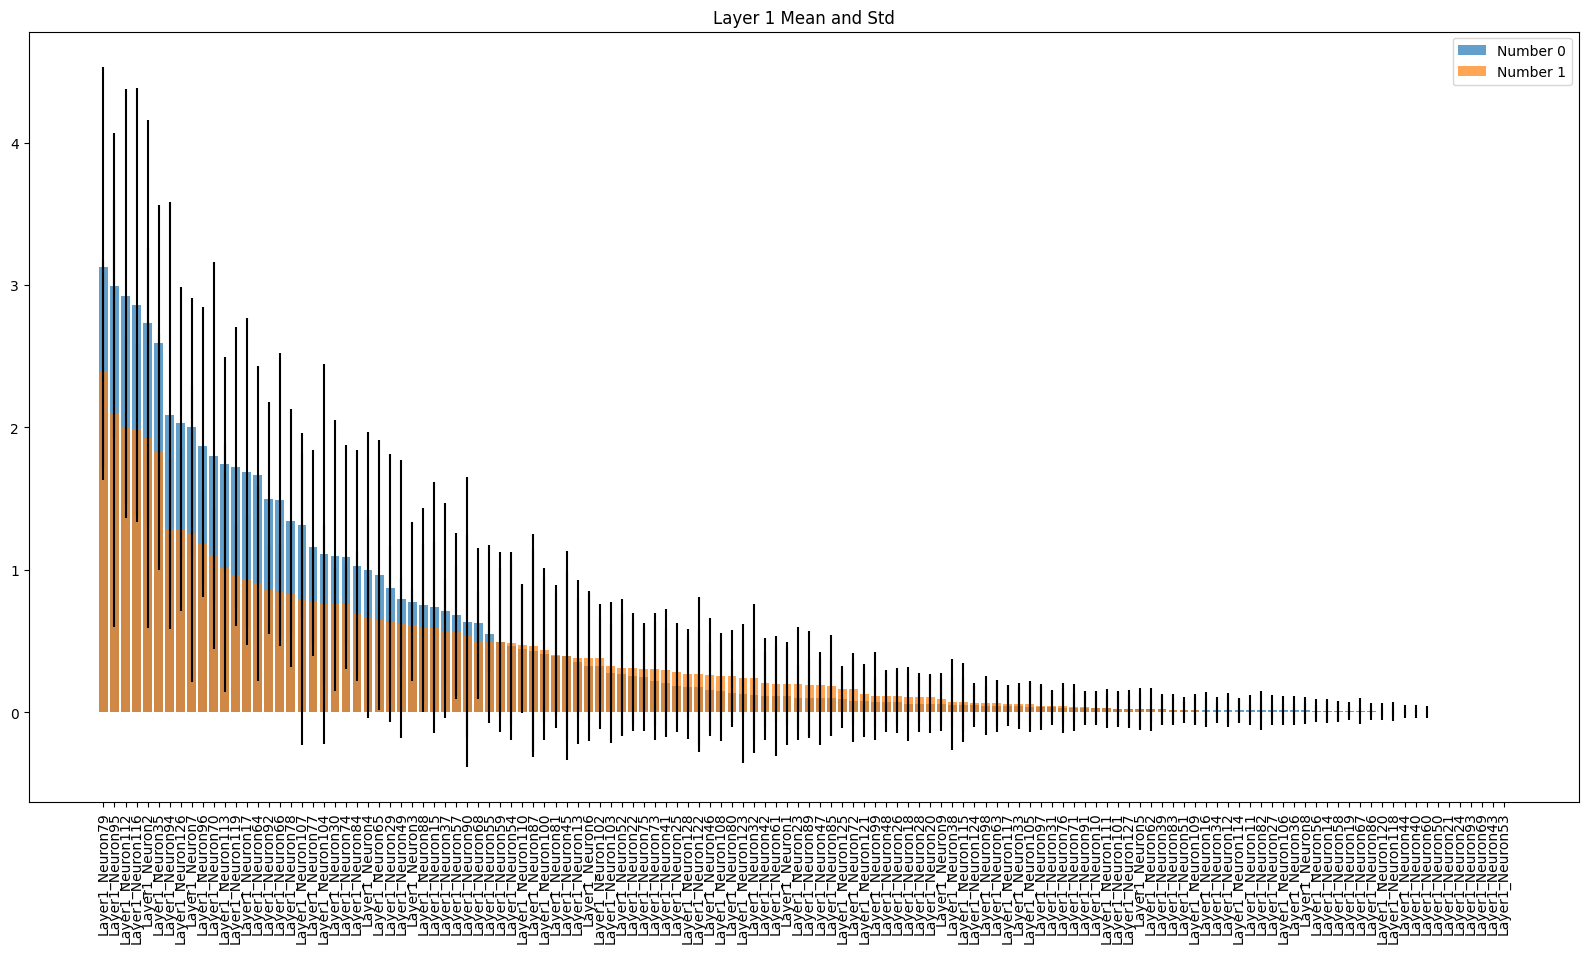

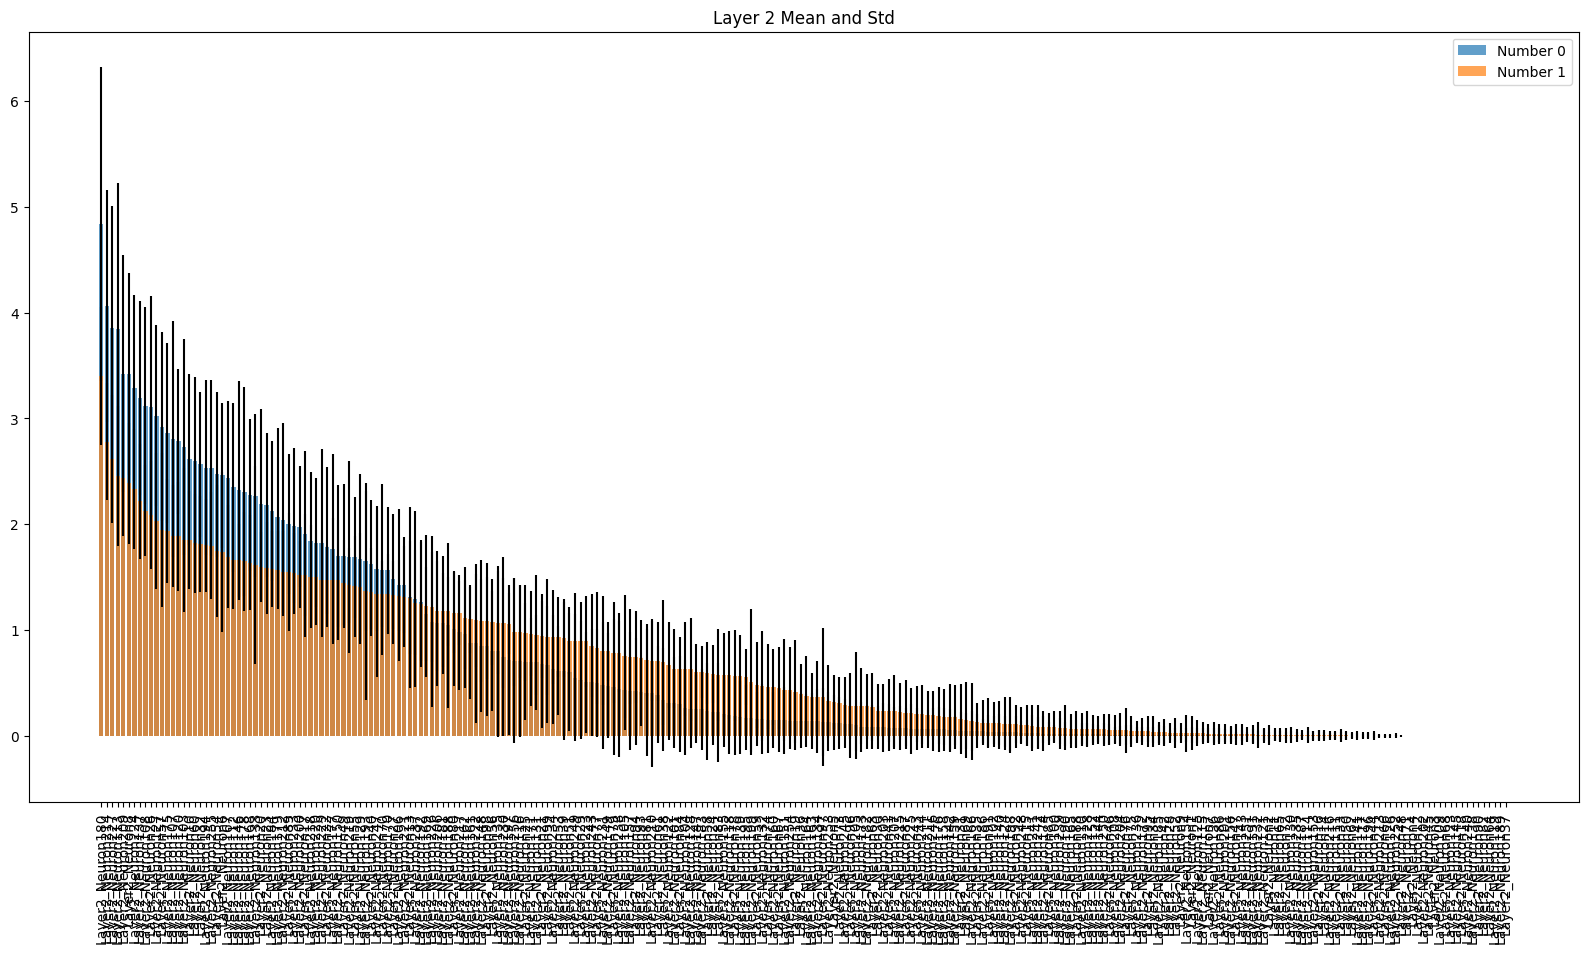

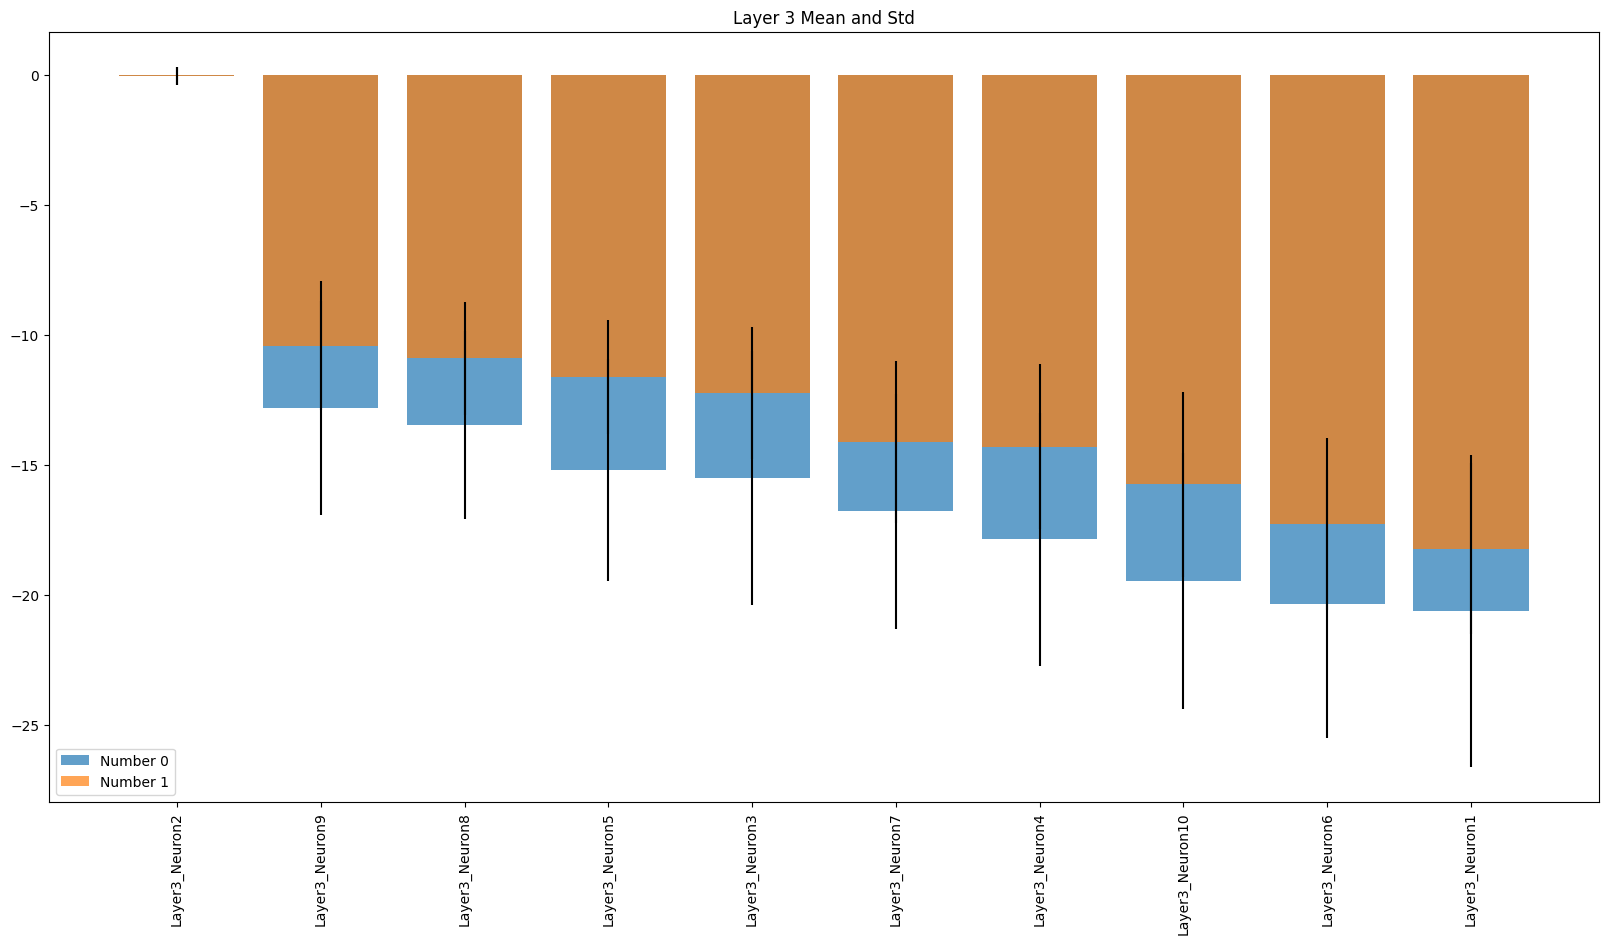

In [34]:
numbers = [0,1]
plot_mean_and_std_bar(df_layer1, 'Layer 1 Mean and Std', numbers=numbers)
plot_mean_and_std_bar(df_layer2, 'Layer 2 Mean and Std', numbers=numbers)
plot_mean_and_std_bar(df_layer3, 'Layer 3 Mean and Std', numbers=numbers)

### Iou for quantiles

In [63]:
def divide_data_by_quartiles(data):
    # Calcula los cuartiles para cada neurona, excluyendo la columna 'Number'
    quartiles = data.drop(columns=['Number']).quantile([0.25, 0.5, 0.75])

    # Función interna para clasificar cada muestra
    def classify_sample(row):
        low, mid_low, mid_high, high = 0, 0, 0, 0
        for neuron, value in row.items():
            if value <= quartiles[neuron][0.25]:
                low += 1
            elif value <= quartiles[neuron][0.5]:
                mid_low += 1
            elif value <= quartiles[neuron][0.75]:
                mid_high += 1
            else:
                high += 1

        max_count = max(low, mid_low, mid_high, high)
        if max_count == low:
            return 'low'
        elif max_count == mid_low:
            return 'mid_low'
        elif max_count == mid_high:
            return 'mid_high'
        else:
            return 'high'

    # Aplica la clasificación a cada fila
    data_by_quartiles = data.drop(columns=['Number']).copy()
    data_by_quartiles['IQR_Class'] = data_by_quartiles.apply(classify_sample, axis=1)
    data_by_quartiles['Number'] = data['Number']

    return data_by_quartiles

def generate_df_by_quartiles(data: pd.DataFrame) -> dict:
    
    data_low = data[data['IQR_Class'] == 'low']
    data_mid_low = data[data['IQR_Class'] == 'mid_low']
    data_mid_high = data[data['IQR_Class'] == 'mid_high']
    data_high = data[data['IQR_Class'] == 'high']

    return {
        'low': data_low,
        'mid_low': data_mid_low,
        'mid_high': data_mid_high,
        'high': data_high
    }





In [60]:
df_layer1_by_quartiles = divide_data_by_quartiles(df_layer1)

In [61]:
df_layer1_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low    10000
Name: count, dtype: int64

In [62]:
df_layer2_by_quartiles = divide_data_by_quartiles(df_layer2)
df_layer2_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low         9941
mid_high      58
mid_low        1
Name: count, dtype: int64

In [70]:
df_layer2_by_quartiles_low = df_layer2_by_quartiles[df_layer2_by_quartiles['IQR_Class'] == 'low']
df_layer2_by_quartiles_low_IoU = IoU(df_layer2_by_quartiles_low.drop(columns=['IQR_Class', 'Number']))
df_layer2_by_quartiles_low_IoU['IoU'].value_counts()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laye

IoU
0.0    45
Name: count, dtype: int64

In [73]:
df_layer2_by_quartiles_mid_high = df_layer2_by_quartiles[df_layer2_by_quartiles['IQR_Class'] == 'mid_high']
df_layer2_by_quartiles_mid_high_IoU = IoU(df_layer2_by_quartiles_mid_high.drop(columns=['IQR_Class', 'Number']))
df_layer2_by_quartiles_mid_high_IoU['IoU'].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laye

IoU
0.0    45
Name: count, dtype: int64

In [64]:
df_layer3_by_quartiles = divide_data_by_quartiles(df_layer3)
df_layer3_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low         3433
mid_low     2446
mid_high    2398
high        1723
Name: count, dtype: int64

## Clf for activations

In [10]:
# set seed for reproducibility in sklearn
SEED = 2024
np.random.seed(SEED)

In [17]:
def train_decision_tree(X, y, test_size=0.3, max_depth=3):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Entrenar el modelo
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)

    # Evaluar el modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)

    return model, report

def visualize_decision_tree(model, feature_names, class_names):

    plt.figure(figsize=(20,10))
    plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names)
    # leyenda
    plt.legend(loc='lower right', fontsize=20)
    # save tree
    plt.savefig('tree.png')
    plt.show()

def visualize_decision_tree_interactive(model, X, y, feature_names, class_names, target_name):

    viz = dtreeviz.model(model, 
                   X, 
                   y, 
                   target_name=target_name, 
                   feature_names=feature_names, 
                   class_names=class_names)
    return viz


In [37]:
X = df_layer1.drop(columns=['Number'])
y = df_layer1['Number']

model, report = train_decision_tree(X, y, max_depth=10)
print(report)

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88       287
         1.0       0.96      0.95      0.95       346
         2.0       0.86      0.83      0.85       336
         3.0       0.84      0.84      0.84       288
         4.0       0.86      0.80      0.83       301
         5.0       0.78      0.81      0.80       253
         6.0       0.94      0.87      0.90       288
         7.0       0.94      0.88      0.91       336
         8.0       0.77      0.84      0.80       263
         9.0       0.80      0.83      0.82       302

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [38]:
X = df_layer2.drop(columns=['Number'])
y = df_layer2['Number']

model, report = train_decision_tree(X, y, max_depth=10)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       270
         1.0       0.97      0.96      0.97       342
         2.0       0.94      0.93      0.93       328
         3.0       0.94      0.95      0.94       319
         4.0       0.92      0.98      0.95       296
         5.0       0.92      0.92      0.92       271
         6.0       0.97      0.93      0.95       306
         7.0       0.96      0.94      0.95       300
         8.0       0.90      0.92      0.91       289
         9.0       0.92      0.91      0.92       279

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [43]:
X = df_layer3.drop(columns=['Number'])
y = df_layer3['Number']

model, report = train_decision_tree(X, y, max_depth=6)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       292
         1.0       0.99      0.98      0.98       326
         2.0       0.99      0.94      0.97       293
         3.0       0.95      0.96      0.96       299
         4.0       0.00      0.00      0.00       308
         5.0       0.25      0.00      0.01       263
         6.0       0.24      1.00      0.39       287
         7.0       0.97      0.98      0.97       313
         8.0       0.00      0.00      0.00       322
         9.0       0.98      0.96      0.97       297

    accuracy                           0.68      3000
   macro avg       0.64      0.68      0.62      3000
weighted avg       0.64      0.68      0.63      3000



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


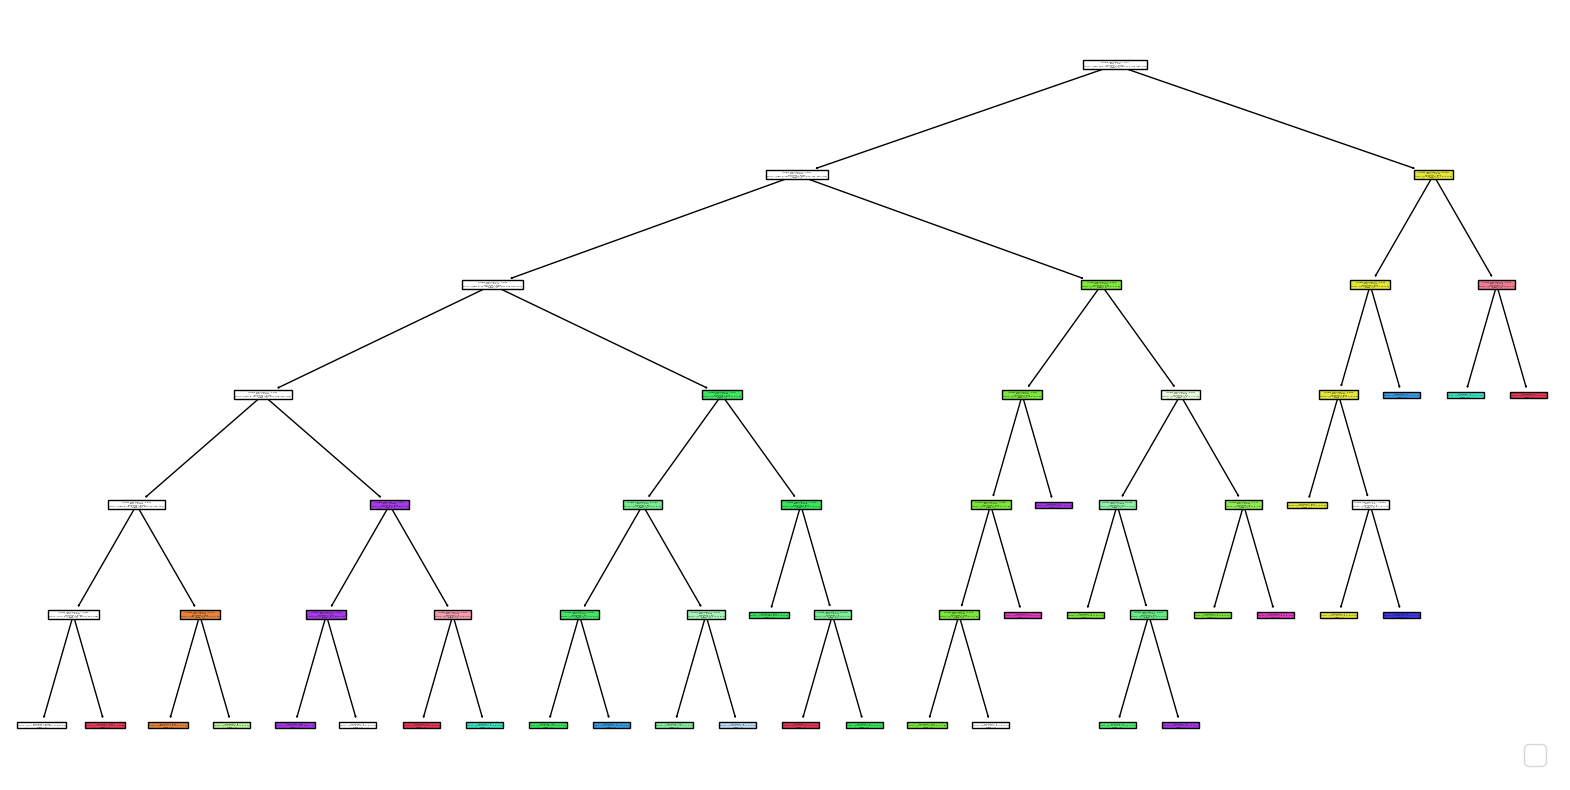

In [44]:
# plot tree

visualize_decision_tree(model, X.columns, [str(i) for i in range(10)])

## Pruining

In [3]:
def find_low_activation_neurons(df, number1, number2, threshold=0.5):
    # 1. Filtrar los datos por número
    df_num1 = df[df['Number'] == number1].drop(columns=['Number'])
    df_num2 = df[df['Number'] == number2].drop(columns=['Number'])

    # 2. Calcular la media de las activaciones
    mean_num1 = df_num1.mean()
    mean_num2 = df_num2.mean()

    # 3. Identificar las neuronas con media inferior al 50% del valor máximo de la media
    threshold_num1 = threshold * mean_num1.max()
    threshold_num2 = threshold * mean_num2.max()
    
    low_neurons_num1 = mean_num1[mean_num1 < threshold_num1].index
    low_neurons_num2 = mean_num2[mean_num2 < threshold_num2].index

    # 4. Calcular la intersección de las neuronas
    intersection_neurons = set(low_neurons_num1).intersection(set(low_neurons_num2))

    # get index form str
    intersection_neurons = [int(i.split('Neuron')[1])-1 for i in intersection_neurons]

    # 5. Retornar la lista de neuronas en la intersección
    return list(intersection_neurons)

In [7]:
class PruningMNISTModel(MNISTModel):

    def apply_neuron_mask(self, layer_output, indices_to_zero):
        mask = torch.ones(layer_output.size(1), device=layer_output.device)
        mask[indices_to_zero] = 0
        return layer_output * mask

    def forward(self, x, record_activations=False, apply_mask=False, mask_indices_layer1=None, mask_indices_layer2=None, mask_indices_layer3=None):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x_layer1 = F.relu(x)

        # Aplicar máscara a la capa 1
        if apply_mask and mask_indices_layer1 is not None:
            x_layer1 = self.apply_neuron_mask(x_layer1, mask_indices_layer1)

        x = self.layer_2(x_layer1)
        x_layer2 = F.relu(x)

        # Aplicar máscara a la capa 2
        if apply_mask and mask_indices_layer2 is not None:
            x_layer2 = self.apply_neuron_mask(x_layer2, mask_indices_layer2)

        x = self.layer_3(x_layer2)
        x_layer3 = F.log_softmax(x, dim=1)

        # Aplicar máscara a la capa 3
        if apply_mask and mask_indices_layer3 is not None:
            x_layer3 = self.apply_neuron_mask(x_layer3, mask_indices_layer3)

        if record_activations:
            return x_layer3, [x_layer1, x_layer2, x_layer3]

        return x_layer3


In [49]:
class PlasticyMNISTModel(MNISTModel):

    def __init__(self, num_classes=10, lr=1e-3, mask_indices_layer1=None, mask_indices_layer2=None, mask_indices_layer3=None):
        super(PlasticyMNISTModel, self).__init__(num_classes=num_classes, lr=lr)

        self.mask_indices_layer1 = mask_indices_layer1
        self.mask_indices_layer2 = mask_indices_layer2
        self.mask_indices_layer3 = mask_indices_layer3

    def apply_neuron_mask(self, layer_output, indices_to_zero):
        mask = torch.ones(layer_output.size(1), device=layer_output.device)
        mask[indices_to_zero] = 0
        return layer_output * mask
    
    def forward(self, x, record_activations=False):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x_layer1 = F.relu(x)

        # Aplicar máscara a la capa 1
        if self.mask_indices_layer1 is not None:
            x_layer1 = self.apply_neuron_mask(x_layer1, self.mask_indices_layer1)

        x = self.layer_2(x_layer1)
        x_layer2 = F.relu(x)

        # Aplicar máscara a la capa 2
        if self.mask_indices_layer2 is not None:
            x_layer2 = self.apply_neuron_mask(x_layer2, self.mask_indices_layer2)

        x = self.layer_3(x_layer2)
        x_layer3 = F.log_softmax(x, dim=1)

        # Aplicar máscara a la capa 3
        if self.mask_indices_layer3 is not None:
            x_layer3 = self.apply_neuron_mask(x_layer3, self.mask_indices_layer3)

        if record_activations:
            return x_layer3, [x_layer1, x_layer2, x_layer3]

        return x_layer3 

In [8]:
# get only class 0 and 1 from test set
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset

class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, classes_to_include):
        self.mnist_dataset = mnist_dataset
        self.filtered_indices = [i for i, (image, label) in enumerate(mnist_dataset) if label in classes_to_include]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        return self.mnist_dataset[self.filtered_indices[idx]]

def load_data(batch_size, classes_to_include, num_workers=4) -> tuple:
    # Transformaciones para los datos
    transform = transforms.ToTensor()

    # Carga de datos de entrenamiento
    mnist_train = datasets.MNIST(os.getcwd(), train=True, download=True, transform=transform)

    # filtrar el dataset para incluir solo clases específicas
    filtered_train_dataset = FilteredMNIST(mnist_train, classes_to_include)

    # División entre entrenamiento y validación
    train_size = int(0.8 * len(filtered_train_dataset))
    val_size = len(filtered_train_dataset) - train_size
    mnist_train, mnist_val = random_split(filtered_train_dataset, [train_size, val_size])

    # DataLoader para entrenamiento y validación
    train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    # Carga de datos de test
    mnist_test = datasets.MNIST(os.getcwd(), train=False, download=True, transform=transform)
    
    # Filtrar el dataset de test para incluir solo clases específicas
    filtered_test_dataset = FilteredMNIST(mnist_test, classes_to_include)

    # DataLoader para el conjunto de datos filtrado
    test_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, val_loader, test_loader

# Uso de la función
classes_to_include = [0, 1]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data(BATCH_SIZE, classes_to_include, num_workers=0)

### Normal Prune

In [163]:
# evaluate model pytorch loop
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            logits = model(x)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total

def evaluate_model_pruning(model, test_loader, mask_indices_layer1=None, mask_indices_layer2=None, mask_indices_layer3=None):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            logits = model(x, apply_mask=True, mask_indices_layer1=mask_indices_layer1, mask_indices_layer2=mask_indices_layer2, mask_indices_layer3=mask_indices_layer3)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total

In [162]:
threshold_layer_1 = 0.15
print(f'Threshold layer 1: {threshold_layer_1*100}%')

mask_indices_layer_1 = find_low_activation_neurons(df_layer1, 0, 1, threshold=threshold_layer_1)
print(f'Low activation neurons layer: {len(mask_indices_layer_1)}')

threshold_layer_2 = 0.15
print(f'Threshold layer 2: {threshold_layer_2*100}%')
mask_indices_layer_2 = find_low_activation_neurons(df_layer2, 0, 1, threshold=threshold_layer_2)
print(f'Low activation neurons layer: {len(mask_indices_layer_2)}')

pruned_model = PruningMNISTModel.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt')

# evaluate normal model
acc = evaluate_model(pruned_model, test_loader_filtered)
print(f'full model accuracy: {acc}')

# evaluate pruned model
acc = evaluate_model_pruning(pruned_model, test_loader_filtered, mask_indices_layer1=mask_indices_layer_1, mask_indices_layer2=mask_indices_layer_2)
print(f'Pruned model accuracy: {acc}')

# calculate the porcentage of neurons pruned
total_neurons = 128+256+10
total_neurons_pruned = len(mask_indices_layer_1) + len(mask_indices_layer_2)
porcentage_pruned = total_neurons_pruned / total_neurons
print(f'Porcentage of neurons pruned: {round(porcentage_pruned*100, 2)}%')

Threshold layer 1: 15.0%
Low activation neurons layer: 51
Threshold layer 2: 15.0%
Low activation neurons layer: 83
full model accuracy: 0.991016548463357
Pruned model accuracy: 0.8439716312056738
Porcentage of neurons pruned: 34.01%


In [168]:
def evaluate_model_with_pruning(model_checkpoint, df_layers, test_loader, neuron_percentages):
    accuracies = []
    total_neurons = 128+256+10

    for percentage in neuron_percentages:
        print(f'Evaluating with {percentage*100}% neurons pruned...')
        mask_indices = {}
        for layer, df_layer in df_layers.items():
            mask_indices[layer] = find_low_activation_neurons(df_layer, 0, 1, threshold=percentage)
            
        print(mask_indices.keys())

        pruned_model = PruningMNISTModel.load_from_checkpoint(model_checkpoint)
        acc = evaluate_model_pruning(pruned_model, test_loader, mask_indices_layer1=mask_indices['layer_1'], mask_indices_layer2=mask_indices['layer_2'])
        accuracies.append(acc)

        neurons_pruned = sum([len(indices) for indices in mask_indices.values()])
        print(f'Neurons pruned: {neurons_pruned} out of {total_neurons} ({neurons_pruned/total_neurons*100:.2f}%)')

    return accuracies

# Usar la función
neuron_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = evaluate_model_with_pruning(
    'lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt',
    {'layer_1': df_layer1, 'layer_2': df_layer2},  # Asumiendo df_layer1 y df_layer2 son los DataFrames de activaciones
    test_loader_filtered,
    neuron_percentages
)

Evaluating with 0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 0 out of 394 (0.00%)
Evaluating with 10.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 100 out of 394 (25.38%)
Evaluating with 20.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 163 out of 394 (41.37%)
Evaluating with 30.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 214 out of 394 (54.31%)
Evaluating with 40.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 267 out of 394 (67.77%)
Evaluating with 50.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 313 out of 394 (79.44%)
Evaluating with 60.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 347 out of 394 (88.07%)
Evaluating with 70.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 360 out of 394 (91.37%)
Evaluating with 80.0% neurons pruned...
dict_keys(['layer_1', 'layer_2'])
Neurons pruned: 369 

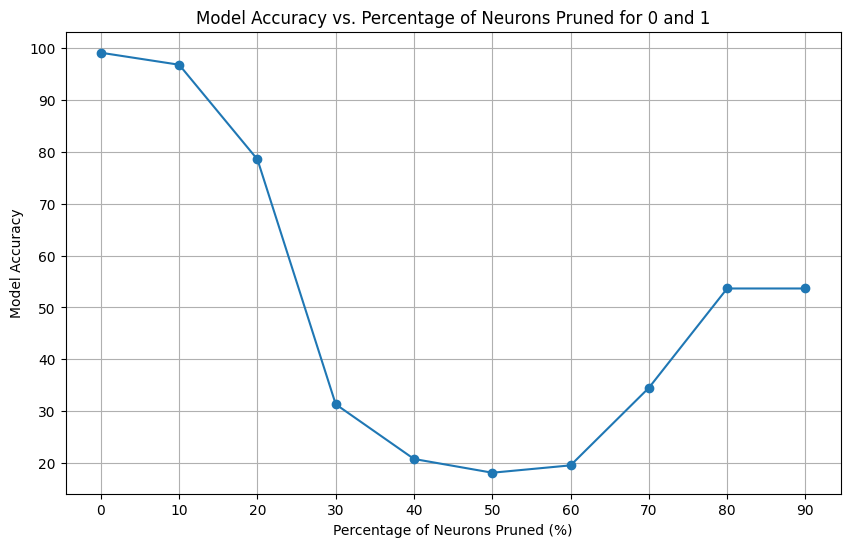

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(neuron_percentages)*100, np.array(accuracies)*100, marker='o')
plt.xlabel('Percentage of Neurons Pruned (%)')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs. Percentage of Neurons Pruned for 0 and 1')
plt.xticks(np.array(neuron_percentages)*100)  # Set x-axis ticks to the percentages
plt.grid(True)
plt.show()

### Neural plasticity

In [11]:
# load checkpoint MNIST model
model_checkpoint = 'lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt'
model = MNISTModel.load_from_checkpoint(model_checkpoint)
model.eval()
print(model)


MNISTModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)


In [12]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_p

Testing DataLoader 0: 100%|██████████| 34/34 [00:01<00:00, 20.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8276250958442688
        precision           0.8305436968803406
         recall             0.8248439431190491
        test_acc            0.9910165667533875
        test_loss           0.03446813300251961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03446813300251961,
  'test_acc': 0.9910165667533875,
  'precision': 0.8305436968803406,
  'recall': 0.8248439431190491,
  'f1': 0.8276250958442688}]

In [15]:
df = pd.read_csv('activations/activations.csv')
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.000000,0.000000,0.000000,0.000000,0.000000,0.196717,0.000000,0.000000,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.000000,0.000000,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.000000,1.838184,0.470426,0.298900,0.000000,0.160310,1.212221,0.000000,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.000000,0.000000,0.000000,0.000000,1.689340,0.451246,0.000000,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782253,2.228824,...,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [17]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

In [20]:
df_layer1 = df[get_layer_columns('Layer1')]
df_layer2 = df[get_layer_columns('Layer2')]
df_layer3 = df[get_layer_columns('Layer3')]

#### First experiment: Masking only second layer

In [77]:
threshold_layer_1 = 0.5
print(f'Threshold layer 1: {threshold_layer_1*100}%')

mask_indices_layer_1 = find_low_activation_neurons(df_layer1, 0, 1, threshold=threshold_layer_1)
print(f'High activation neurons layer: {128 - len(mask_indices_layer_1)}')

Threshold layer 1: 50.0%
High activation neurons layer: 24


In [78]:
threshold_layer_2 = 0.5
print(f'Threshold layer 2: {threshold_layer_2*100}%')

mask_indices_layer_2 = find_low_activation_neurons(df_layer2, 0, 1, threshold=threshold_layer_2)

print(f'High activation neurons layer: {256 - len(mask_indices_layer_2)}')

Threshold layer 2: 50.0%
High activation neurons layer: 47


In [57]:
mask_indices_layer_3 = [2, 3, 4, 5, 6, 7, 8, 9]

In [79]:
# load plasticy model
plasticy_model = PlasticyMNISTModel.load_from_checkpoint(model_checkpoint, mask_indices_layer1=mask_indices_layer_1, mask_indices_layer2=mask_indices_layer_2, mask_indices_layer3=None)
print(plasticy_model)

PlasticyMNISTModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)


In [80]:
# train plasticy model
plasticy_model_trainer = pl.Trainer(max_epochs=5)
plasticy_model_trainer.fit(plasticy_model, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 33.0 K
2 | layer_3   | Linear              | 2.6 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision | MulticlassPrecision | 0     
7 | recall    | MulticlassRecall    | 0     
8 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 159/159 [00:01<00:00, 103.76it/s, v_num=25, train_loss=4.83e-5, train_acc=1.000, val_loss=0.00575, val_acc=0.998] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 159/159 [00:01<00:00, 103.29it/s, v_num=25, train_loss=4.83e-5, train_acc=1.000, val_loss=0.00575, val_acc=0.998]


In [81]:
plasticy_model_trainer.test(plasticy_model, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: PossibleUserWarning: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 99.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.9995242953300476
        precision           0.9995676875114441
         recall             0.9994956851005554
        test_acc            0.9995272159576416
        test_loss          0.0013040086487308145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0013040086487308145,
  'test_acc': 0.9995272159576416,
  'precision': 0.9995676875114441,
  'recall': 0.9994956851005554,
  'f1': 0.9995242953300476}]

In [88]:
_, _, test_loader_filtered_bs_1 = load_data(1, classes_to_include, num_workers=0)

In [89]:
layer1_neurons = 128 
layer2_neurons = 256 
layer3_neurons = 10 

# Creación de las columnas para cada neurona
columns = ['Number']
columns += [f'Layer1_Neuron{i+1}' for i in range(layer1_neurons)]
columns += [f'Layer2_Neuron{i+1}' for i in range(layer2_neurons)]
columns += [f'Layer3_Neuron{i+1}' for i in range(layer3_neurons)]

# Estimación del tamaño del DataFrame (ajusta según tu conjunto de datos)
num_rows = len(test_loader_filtered_bs_1)

# Pre-creación del DataFrame
df = pd.DataFrame(index=range(num_rows), columns=columns)

# Llenar el DataFrame
for idx, batch in enumerate(tqdm(test_loader_filtered_bs_1, desc='Running activations')):
    x, y = batch
    _, r = plasticy_model(x, record_activations=True)

    
    row = {'Number': y.item()}
    row.update({f'Layer1_Neuron{i+1}': r[0].cpu().detach().numpy()[0, i] for i in range(layer1_neurons)})
    row.update({f'Layer2_Neuron{i+1}': r[1].cpu().detach().numpy()[0, i] for i in range(layer2_neurons)})
    row.update({f'Layer3_Neuron{i+1}': r[2].cpu().detach().numpy()[0, i] for i in range(layer3_neurons)})

    df.loc[idx] = row

Running activations: 100%|██████████| 2115/2115 [00:02<00:00, 705.21it/s]


In [91]:
# save activations csv
df.to_csv('activations/activations_pruning_l1_50_l2_50.csv', index=False)

##### Plasticity study

In [93]:
# read activations csv
folder = os.path.join(os.getcwd(), 'activations', 'activations_pruning_l1_50_l2_50.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,1.0,0.0,1.546783,0.0,0.0,0.029745,0.0,2.014915,2.388911,2.739611,...,-8.874018e+00,-0.000313,-10.534051,-10.170124,-12.502811,-12.079916,-13.526888,-10.442421,-10.141003,-10.444499
1,0.0,0.0,2.328155,0.0,0.0,0.000000,0.0,7.273946,7.943891,6.265548,...,-1.192093e-07,-16.298635,-20.867790,-23.345730,-23.041527,-25.399738,-25.469765,-19.179956,-23.428671,-19.677645
2,1.0,0.0,0.702154,0.0,0.0,0.000000,0.0,3.302713,3.408653,3.471348,...,-1.068659e+01,-0.000032,-13.334956,-12.951073,-15.850660,-15.941042,-17.769787,-13.382990,-13.122014,-13.270432
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.512084,5.727099,6.861275,...,-8.821448e-06,-12.250895,-15.326880,-16.173672,-15.680816,-17.285982,-18.117065,-13.860162,-16.191128,-12.924178
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3.574657,6.477502,5.938462,...,-5.483612e-06,-12.305979,-16.493258,-17.622999,-17.377651,-19.175255,-20.161188,-15.118809,-17.839720,-14.233232


In [96]:
def plot_mean_and_std_bar(df: pd.DataFrame, title: str, numbers: list):
    if not numbers:
        raise ValueError('You must provide at least one number')

    plt.figure(figsize=(20, 10))

    # Iterar sobre cada número para calcular la media y la desviación estándar
    for num in numbers:
        # Seleccionar las filas para cada número
        df_num = df[df['Number'] == num]
        df_num = df_num.drop(columns=['Number'])

        # Calcular la media y la desviación estándar
        mean = df_num.mean().sort_values(ascending=False)
        std = df_num.std()[mean.index]  # Asegurarse de que std corresponda a la media ordenada

        # Índices de las barras
        bar_indexes = range(1, len(mean) + 1)

        # Graficar la media y la desviación estándar
        plt.bar(bar_indexes, mean, yerr=std, label=f'Number {num}', alpha=0.7)

    plt.title(title)
    plt.xticks(ticks=bar_indexes, labels=mean.index, rotation=90)
    plt.legend()
    plt.show()

In [97]:
df_layer1 = df[get_layer_columns('Layer1')]
df_layer2 = df[get_layer_columns('Layer2')]
df_layer3 = df[get_layer_columns('Layer3')]
numbers = [0,1]

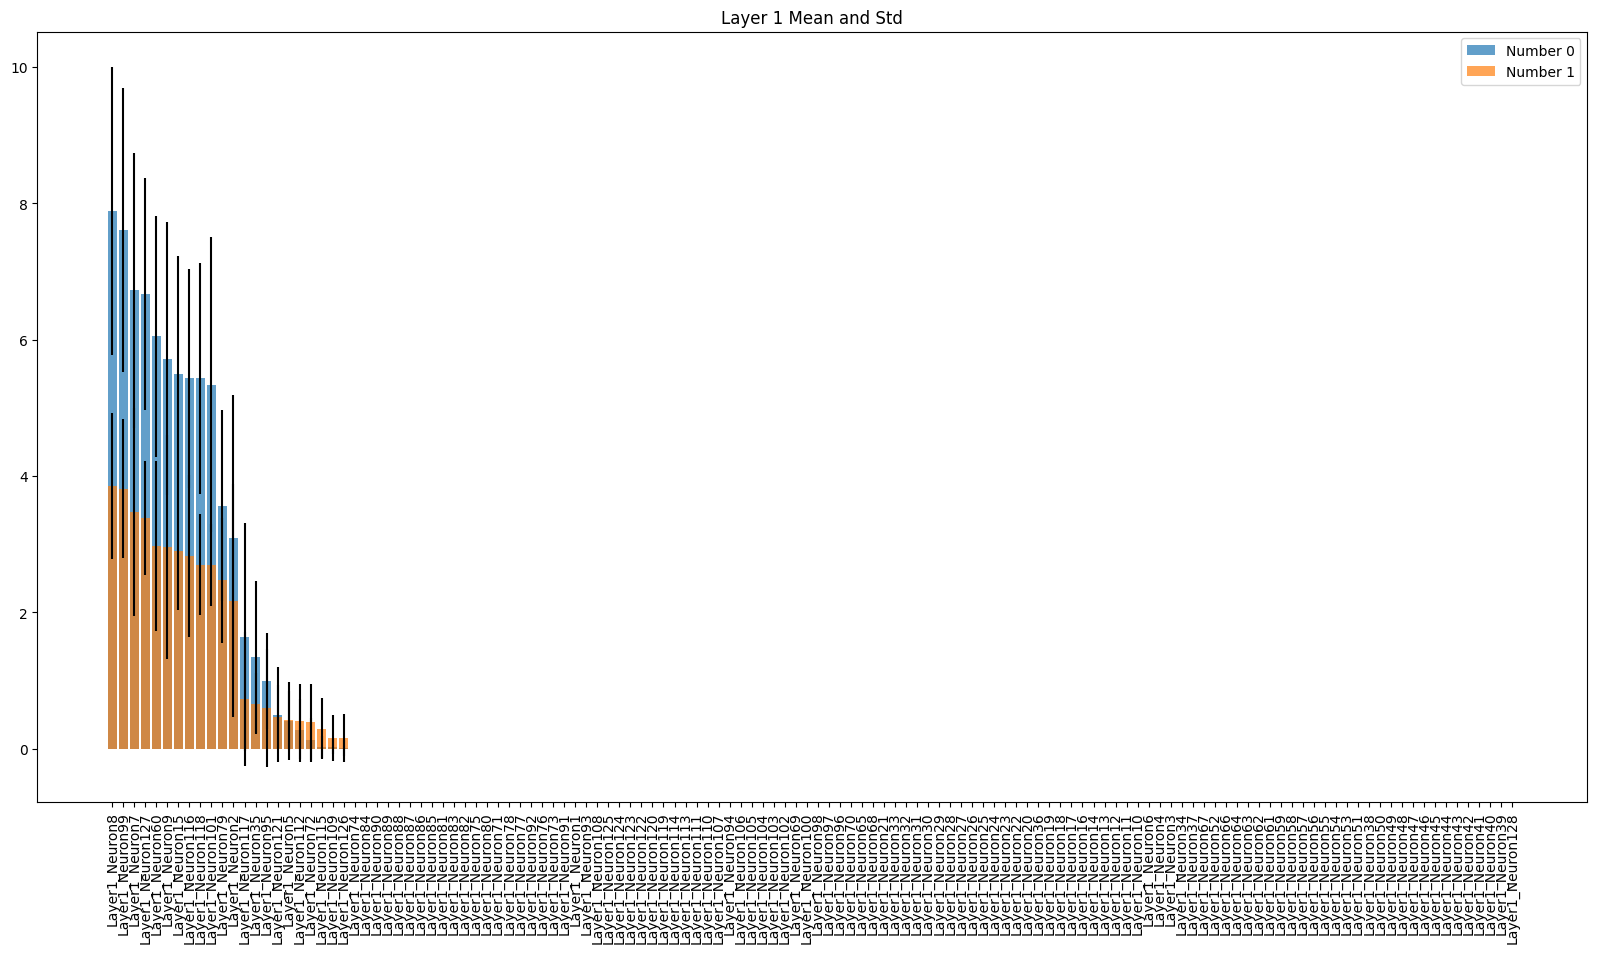

In [98]:
plot_mean_and_std_bar(df_layer1, 'Layer 1 Mean and Std', numbers=numbers)

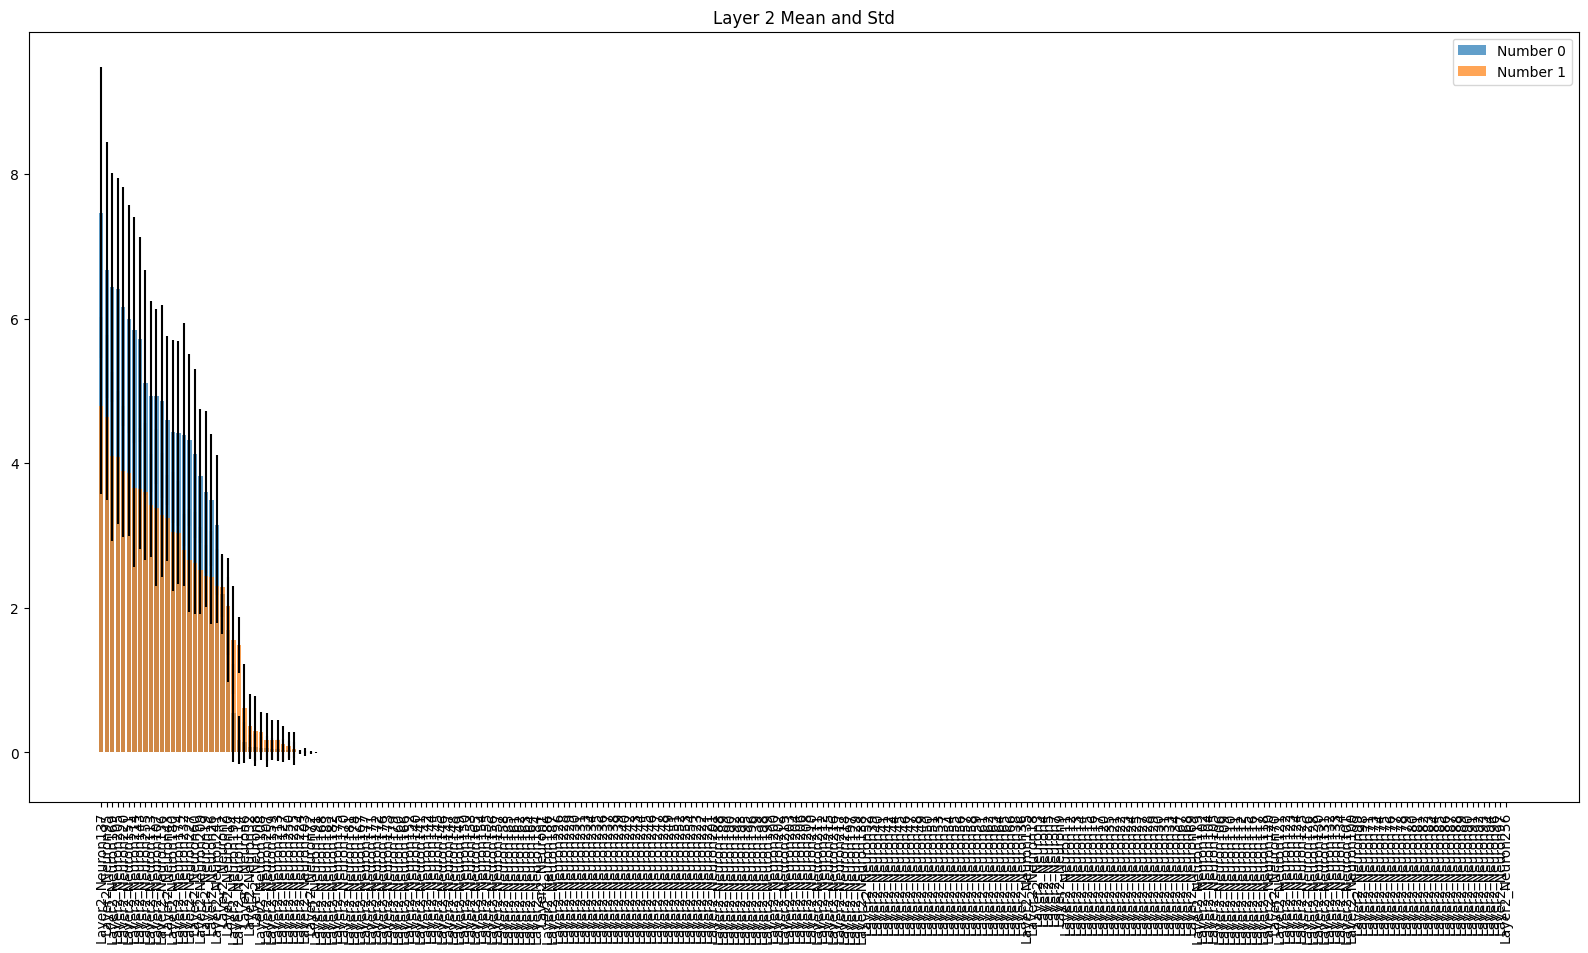

In [99]:
plot_mean_and_std_bar(df_layer2, 'Layer 2 Mean and Std', numbers=numbers)

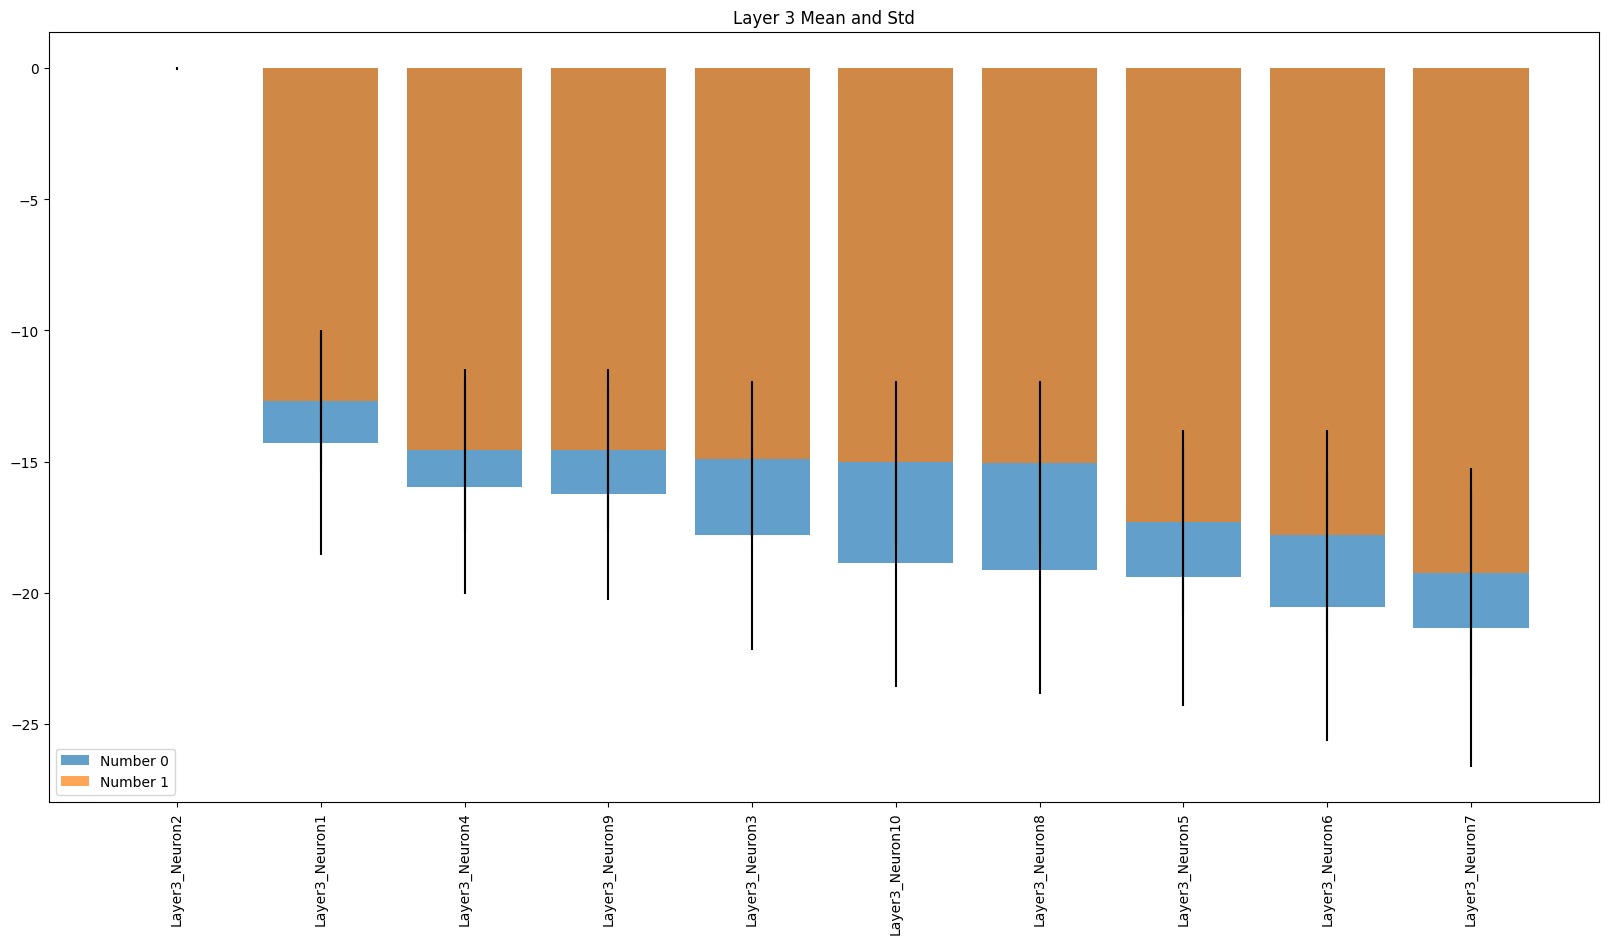

In [100]:
plot_mean_and_std_bar(df_layer3, 'Layer 3 Mean and Std', numbers=numbers)